# Using AutoBound to compute "safe" learning rates

This notebook shows how AutoBound can be used to compute learning rates that are guaranteed to monotonically reduce a loss function.  This application is discussed in more detail in Chapter 5 of [the AutoBound paper](https://arxiv.org/abs/2212.11429).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/autobound/blob/main/autobound/notebooks/safe_learning_rates.ipynb)

## Install autobound

In [ ]:
%pip install autobound

## Compute safe learning rates

Given a loss function $f$ and an iterate $x_t$, we will compute a learning rate
that is guaranteed to reduce the loss by
1. Computing a quadratic upper bound on the function $h_t(\eta) \triangleq f(x_t - \eta \nabla f(x_t))$.  The quadratic upper bound will be valid over the interval $[0, \bar \eta]$, where $\bar \eta$ is a maximum learning rate.
2. Minimizing the quadratic upper bound on $h_t$ to obtain a learning rate $\eta_t$.

This gives a learning rate $\eta_t$ that is guaranteed to monotonically reduce the loss, because  $f(x_t - \eta_t \nabla f(x_t)) = h_t(\eta_t) \le h_t(0) = f(x_t)$.

To do the first step, we define a helper function that upper bounds the loss as a function of the learning rate.

In [1]:
import autobound.jax as ab


def bound_loss(x, update_dir, max_learning_rate):
  """Upper bound the loss as a function of the learning rate."""
  def next_loss(learning_rate):
    next_x = jax.tree_util.tree_map(lambda w, v: w + learning_rate*v, x,
                                    update_dir)
    return loss(next_x)

  trust_region = (0., max_learning_rate)
  return ab.taylor_bounds(next_loss, 2)(0., trust_region)

Let's test this helper function by upper bounding a one-dimensional loss and plotting the results.

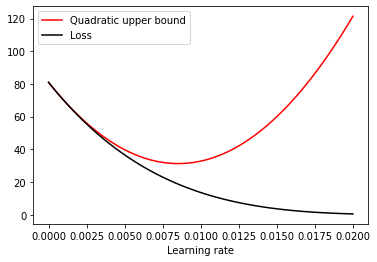

In [2]:
import jax
from matplotlib import pyplot
import numpy as np

loss = lambda x: (x-3)**4  # We could use a more complex loss here.
x0 = 0.
update_dir = -jax.grad(loss)(x0)
max_learning_rate = .02

next_loss = jax.jit(lambda eta: loss(x0 + eta*update_dir))

bound = bound_loss(x0, update_dir, max_learning_rate)
etas = np.linspace(0, max_learning_rate, 101)
pyplot.plot(etas, [bound.upper(eta) for eta in etas], 'r',
            label='Quadratic upper bound')
pyplot.plot(etas, [next_loss(eta) for eta in etas], 'k',
            label='Loss')
pyplot.xlabel('Learning rate')
pyplot.legend()
pyplot.show()


To minimize the quadratic upper bound, we define a helper function.

In [3]:
import jax.numpy as jnp


def minimize_1d_quadratic(c1, c2, trust_region):
  """Minimizes c1*x + c2*x**2 over trust_region."""
  a, b = trust_region
  a, b, c1, c2 = [jnp.asarray(x) for x in [a, b, c1, c2]]
  # If c2 > 0, we set the derivative to zero to get -c1/(2*c2), then project
  # this into the trust_region to get the minimizer.
  project = lambda x: jnp.minimum(b, jnp.maximum(a, x))
  c2_pos_solution = project(jnp.divide(-c1, 2*c2))
  # If c2 < 0, the minimizer is one of the two endpoints.
  q = lambda x: c1*x + c2*x**2
  c2_neg_solution = jnp.where(q(a) < q(b), a, b)
  # If c2 == 0, the minimizer depends on the sign of c1.
  c2_zero_solution = (jnp.equal(c1, 0.) * project(0.) +
                      jnp.greater(c1, 0.) * a + jnp.less(c1, 0.) * b)
  c2_nonzero_solution = jnp.where(c2 > 0., c2_pos_solution, c2_neg_solution)
  return jnp.where(c2 == 0., c2_zero_solution, c2_nonzero_solution)


assert float(minimize_1d_quadratic(-1., 2., (0., 1.))) == .25

Using this helper function, we can create a function that computes a safe learning rate for a given loss.

In [4]:
import jax


def safe_learning_rate(x, update_dir, max_learning_rate):
  bounds = bound_loss(x, update_dir, max_learning_rate)
  if len(bounds.coefficients) < 3:
    raise NotImplementedError()  # the loss is linear 
  c1 = bounds.coefficients[1]
  c2 = bounds.final_interval()[1]
  trust_region = (0., max_learning_rate)
  return minimize_1d_quadratic(c1, c2, trust_region)


# If the function is a 1-d quadratic, the safe learning rate should take us
# to the global minimum in one step.
loss = lambda x: (x-1)**2
x0 = 0.
update_dir = -jax.grad(loss)(x0)
safe_eta = safe_learning_rate(x0, update_dir, 1e12)
assert float(loss(x0 + safe_eta*update_dir)) == 0.

Let's examine how the safe learning rate changes as a function of the maximum learning rate.

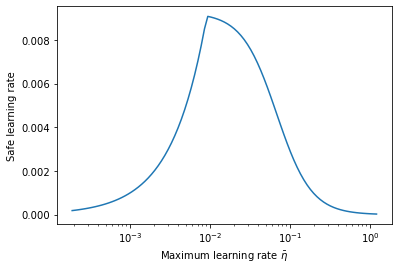

In [5]:
from matplotlib import pyplot

loss = lambda x: (x-3)**4
x0 = 0.
update_dir = -jax.grad(loss)(x0)

safe_eta = jax.jit(
    lambda max_rate: safe_learning_rate(x0, update_dir, max_rate))
max_rates = [1.1**i for i in range(-90, 3)]

pyplot.plot(max_rates, [safe_eta(r) for r in max_rates])
pyplot.xlabel('Maximum learning rate $\\bar \\eta$')
pyplot.xscale('log')
pyplot.ylabel('Safe learning rate')
pyplot.show()


As can be seen, if the maximum learning rate is too large or too small, we will end up computing a very conservative learning rate.  Thus, we would like to find a maximum learning rate that is in the right ballpark.

The SafeRate optimizer defined  Chapter 5 of [the AutoBound paper](https://arxiv.org/abs/2212.11429) uses a simple doubling/halving rule to adapt the maximum learning rate over time.  We implement SafeRate below.

In [6]:

def saferate_optimizer(loss, initial_max_eta: float = 1.):
  def init_fun(x0):
    return (x0, 0., initial_max_eta)

  def update_state(state):
    x, _, max_eta = state
    jax.tree_util.tree_map(lambda v: -v, jax.grad(loss)(x))
    safe_eta = safe_learning_rate(x, update_dir, max_eta)
    next_x = jax.tree_util.tree_map(
        lambda p, v: p + safe_eta*v, x, update_dir
    )
    next_max_eta = jnp.where(
        # If safe_eta is NaN, we cut the learning rate in half.
        jnp.logical_or(safe_eta < max_eta / 2, safe_eta > safe_eta),
        max_eta / 2,
        max_eta * 2
    )
    return (next_x, safe_eta, next_max_eta)

  def get_params(state):
    x, _, _ = state
    return x

  return init_fun, update_state, get_params

Finally, let's try running the SafeRate optimizer.

step = 0 loss = 81.0 learning_rate = 4.26694e-05
step = 1 loss = 80.50344 learning_rate = 0.00016758488
step = 2 loss = 78.5753 learning_rate = 0.0006248287
step = 4 loss = 53.016552 learning_rate = 0.004076681
step = 8 loss = 0.50487447 learning_rate = 0.002497403
step = 16 loss = 8.26129e-06 learning_rate = 0.00015905696
step = 32 loss = 2.0091494e-15 learning_rate = 6.286466e-07
step = 64 loss = 3.2311743e-27 learning_rate = 7.1466083e-10



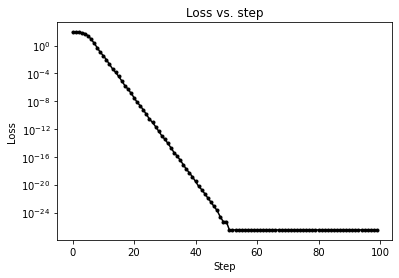

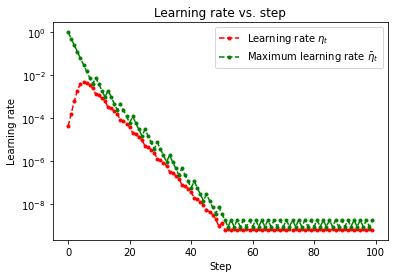

In [7]:
from matplotlib import pyplot

loss = lambda x: (x-3)**4
loss_jit = jax.jit(loss)
x0 = 0.

init_fun, update_state, get_params = saferate_optimizer(loss)
update_state = jax.jit(update_state)

state = init_fun(x0)
step_to_data = {}
for step in range(100):
  cur_loss = loss_jit(get_params(state))
  max_rate = state[2]
  state = update_state(state)
  rate = state[1]
  step_to_data[step] = (cur_loss, rate, max_rate)
  if step & (step - 1) == 0:
    print('step =', step, 'loss =', cur_loss, 'learning_rate =', rate)
print()

# Plot the loss as a function of step.
steps = sorted(step_to_data.keys())
pyplot.plot(steps, [step_to_data[step][0] for step in steps], 'k', marker='.')
pyplot.xlabel('Step')
pyplot.ylabel('Loss')
pyplot.yscale('log')
pyplot.title('Loss vs. step')
pyplot.show()
print()

# Plot the learning rate as a function of step.
pyplot.plot(steps, [step_to_data[step][1] for step in steps], 'r--', marker='.',
            label='Learning rate $\\eta_t$')
pyplot.plot(steps, [step_to_data[step][2] for step in steps], 'g--', marker='.',
            label='Maximum learning rate $\\bar \\eta_t$')
pyplot.xlabel('Step')
pyplot.yscale('log')
pyplot.ylabel('Learning rate')
pyplot.title('Learning rate vs. step')
pyplot.legend()
pyplot.show()

